**This code is for training vgg 16 model for 60 epoch 20 epoch per model i.e model will be retrained by reuploading but saving with different names.**

# ***change the paths value as per your driver location for the segmented data and to save and upload the model***
1.   **Record weight(preferable screen record 'in form of video') due to large numbers**
*   need superviser guidence to put this data in report
2.   **record graph and final output accuracy 'screenshot'**

In [ ]:
# Connection to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
#import zipfile
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import classification_report, log_loss, accuracy_score

In [ ]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'


In [ ]:
# below path is combination of paths i.e training/segmented will be added after source_path to create new path

In [ ]:
Training_DIR = os.path.join(source_path, 'training/segmented')
Validation_DIR = os.path.join(source_path, 'testing/segmented')

In [ ]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2968 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 600 images belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.VGG19(input_shape=(256,256,3),
                                                include_top=False,
                                                weights='imagenet')

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Get the block5_conv3 layer
block5_conv4 = pretrained_model.get_layer('block5_conv4')

# Get the weights of the layer
weights = block5_conv4.get_weights()
print(weights)
#first array is flattened value of (filter_height , filter_width , input_channels , output_channels)
#second 1 dimension array is bias value

[array([[[[-4.64460906e-03,  1.46970386e-02,  3.23988590e-03, ...,
          -4.33280692e-03, -8.06200609e-04,  2.47608847e-03],
         [ 5.03372960e-03, -5.71580091e-03,  6.78836554e-03, ...,
           1.08196763e-02,  3.62628512e-03,  1.43926090e-03],
         [-6.81616180e-03,  6.24293694e-03,  1.04397337e-03, ...,
          -1.91838283e-03,  8.97154212e-03,  1.37661071e-03],
         ...,
         [ 2.83825444e-03, -7.85127282e-03, -5.45571279e-03, ...,
          -3.88198742e-03,  1.94512017e-03, -3.39086540e-03],
         [ 8.18251166e-03,  4.36121924e-03, -1.82194239e-03, ...,
          -6.19367976e-03, -1.13867195e-02, -7.39785610e-03],
         [-6.48834568e-04,  1.49349002e-02,  1.63981728e-02, ...,
           1.25553356e-02,  6.70782290e-03, -4.48068931e-05]],

        [[-5.89831220e-03,  1.63694508e-02,  5.88402897e-03, ...,
           2.22208491e-03,  7.25099060e-04,  3.70497908e-03],
         [ 6.45378651e-03, -2.95020780e-03,  6.38980558e-03, ...,
           9.81882587

In [ ]:
# for fine tuning block5_conv4 only
# fine tuning - updating the weight and bios value for our dataset during training
layer_index = [index for index, layer in enumerate(pretrained_model.layers) if layer.name == "block5_conv4"][0]
layer = pretrained_model.layers[layer_index]

for i, layer in enumerate(pretrained_model.layers):
    if i == layer_index:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# adding dense layer to train the model
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# create a model object
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# training rate used in vgg16 0.001
# tell the model what cost and optimization method to use

from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

from keras.callbacks import EarlyStopping
# Define a callback that stops training when the accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, min_delta=0.001, mode='max')

#since learning rate was not defined so default for adam will be used i.e 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train = model.fit(training_set,
                validation_data = test_set, 
                epochs = 200, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr, early_stopping]
                )


Epoch 1/200
93/93 [==============================] - 689s 7s/step - loss: 1.3293 - accuracy: 0.5991 - val_loss: 2.9015 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 2/200
93/93 [==============================] - 60s 643ms/step - loss: 0.8040 - accuracy: 0.6863 - val_loss: 2.0166 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 3/200
93/93 [==============================] - 61s 659ms/step - loss: 0.7424 - accuracy: 0.7187 - val_loss: 0.7268 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 4/200
93/93 [==============================] - 63s 677ms/step - loss: 0.6885 - accuracy: 0.7513 - val_loss: 4.6458 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 5/200
93/93 [==============================] - 61s 651ms/step - loss: 0.6400 - accuracy: 0.7702 - val_loss: 1.1217 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 6/200
93/93 [==============================] - 62s 671ms/step - loss: 0.6209 - accuracy: 0.7625 - val_loss: 15.0518 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 7/200
93/93 [==============================] - 61s 65

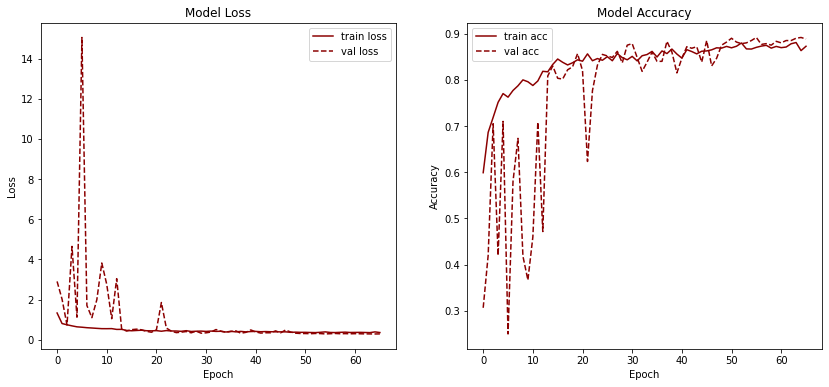

In [ ]:
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

Final Train Accuracy: 0.8726415038108826
Final Test Accuracy: 0.8883333206176758
Final Train Loss: 0.3557319641113281
Final Test Loss: 0.2880920171737671


In [ ]:
# save it as a h5 file
tf.keras.models.save_model(model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/vgg19.h5')